In [21]:
from shapely.geometry import mapping
geom = mapping(kc_dataset.gdf.iloc[0]["geometry"])
print(geom)


{'type': 'MultiPolygon', 'coordinates': [(((1003506.0000254177, 1890264.0000116676), (1003506.0000254177, 1890273.9999916703), (1003508.0000214167, 1890273.9999916703), (1003508.0000214167, 1890264.0000116676), (1003506.0000254177, 1890264.0000116676)),)]}


Loading vector data from path: /net/projects/cmap/data/kane-county-data/KC_CountywideDepressionalStorage_Aug2020.gdb, layer: DepressionalStorage
'BasinType' not found. Available keys: ['ContourMin', 'ContourMax', 'Shape_Leng', 'fid_1', 'Shape_Length', 'Shape_Area']
Falling back to 'fid_1'.
GeoDataFrame has no CRS. Setting CRS to EPSG:3435.
Loaded 100 vector features. Assigned default label 1 to all features.
Converting vector data to CRS EPSG:3435...
Finished loading vector data.
Generating visualization 1...
IOU for visualization 1: 1.000


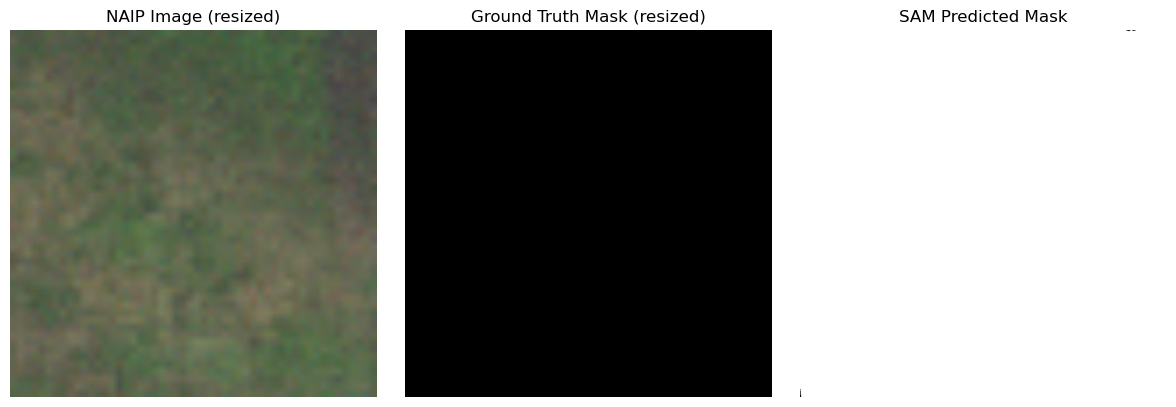

Generating visualization 2...
IOU for visualization 2: 0.649


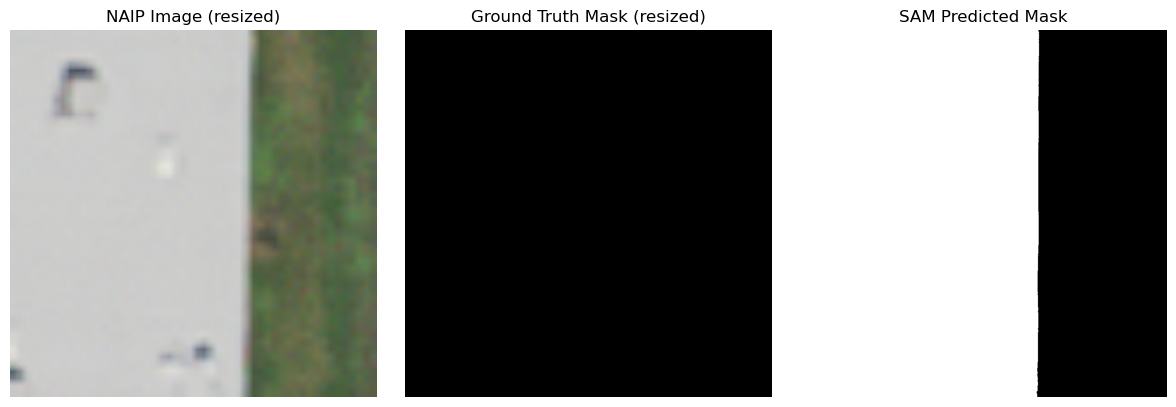

Generating visualization 3...
IOU for visualization 3: 0.195


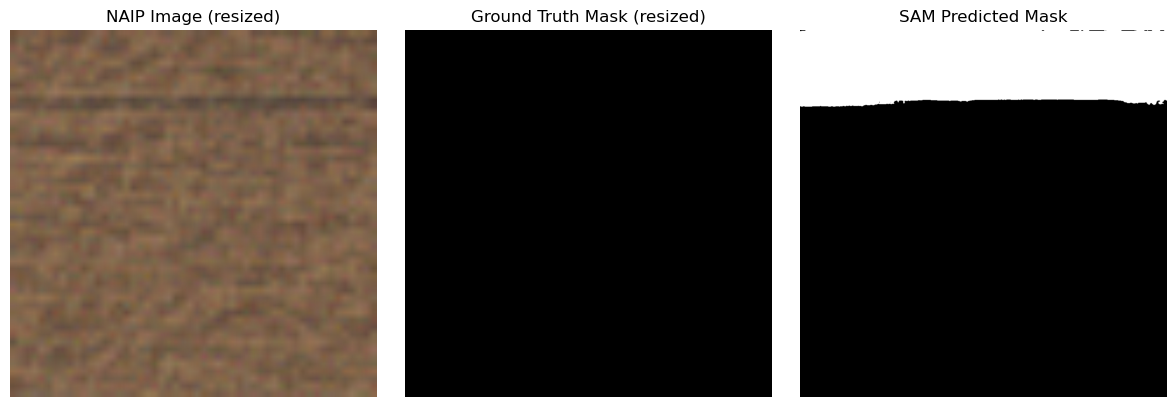

Generating visualization 4...
IOU for visualization 4: 0.336


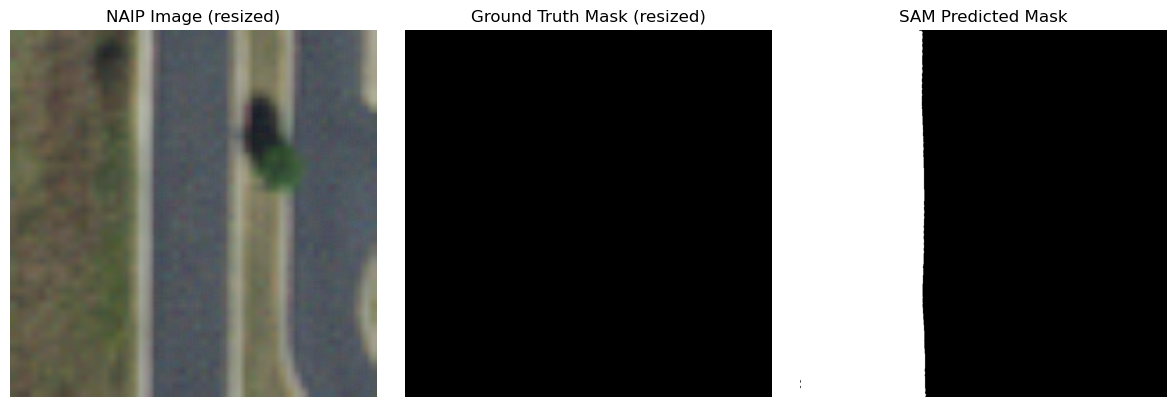

Generating visualization 5...
IOU for visualization 5: 0.856


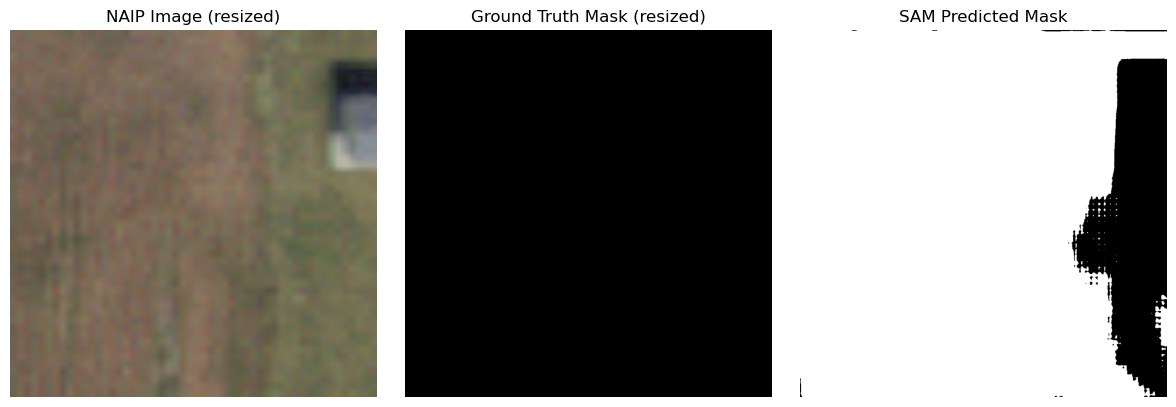

In [39]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from torchgeo.datasets import BoundingBox, NAIP
from pyproj import Transformer
from PIL import Image
from kc import KaneCounty
from segment_anything import SamPredictor, sam_model_registry

# --- Configuration parameters ---
vector_path = "/net/projects/cmap/data/kane-county-data/KC_CountywideDepressionalStorage_Aug2020.gdb"
layer = "DepressionalStorage"
vector_crs = "EPSG:3435"  # assumed vector CRS
default_labels = {0: "BACKGROUND", 1: "OBJECT"}
dataset_config = (layer, default_labels, 256, vector_crs, 1.0)

# --- Load datasets ---
kc_dataset = KaneCounty(vector_path, dataset_config)
naip_dataset = NAIP("/net/projects/cmap/data/KC-images")

# --- SAM Model Setup ---
model_type = "vit_h"
checkpoint_path = "/home/gregoryc25/CMAP/segment-anything/sam_vit_h.pth"
sam_model = sam_model_registry[model_type](checkpoint=checkpoint_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model.to(device)
predictor = SamPredictor(sam_model)

# --- Utility Functions ---
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1 > 0, mask2 > 0).sum()
    union = np.logical_or(mask1 > 0, mask2 > 0).sum()
    return intersection / union if union > 0 else 0

def query_valid_tile(kc_dataset, vector_bounds, tile_size=100, max_attempts=50):
    for _ in range(max_attempts):
        minx, miny, maxx, maxy = vector_bounds
        rand_minx = random.uniform(minx, maxx - tile_size)
        rand_miny = random.uniform(miny, maxy - tile_size)
        bbox = BoundingBox(minx=rand_minx, maxx=rand_minx + tile_size,
                           miny=rand_miny, maxy=rand_miny + tile_size,
                           mint=0, maxt=2**63-1)
        sample = kc_dataset[bbox]
        gt_mask = sample["mask"].numpy()
        if np.sum(gt_mask != 0) > 0:
            return bbox, gt_mask
    raise ValueError("No valid vector tile found after 50 attempts")

# --- Generate 5 images ---
vector_bounds = kc_dataset.gdf.total_bounds
for i in range(5):
    print(f"Generating visualization {i + 1}...")

    # --- Query a valid tile ---
    bbox, gt_mask = query_valid_tile(kc_dataset, vector_bounds)

    # --- Select a random non-background point ---
    non_bg_coords = np.column_stack(np.where(gt_mask != 0))
    selected_point = non_bg_coords[random.randint(0, len(non_bg_coords)-1)]
    prompt_point = [int(selected_point[1]), int(selected_point[0])]

    # --- Transform bounding box for NAIP query ---
    transformer = Transformer.from_crs(vector_crs, naip_dataset.crs, always_xy=True)
    new_minx, new_miny = transformer.transform(bbox.minx, bbox.miny)
    new_maxx, new_maxy = transformer.transform(bbox.maxx, bbox.maxy)
    bbox_naip = BoundingBox(minx=new_minx, maxx=new_maxx, miny=new_miny, maxy=new_maxy,
                            mint=bbox.mint, maxt=bbox.maxt)

    # --- Query and resize NAIP image ---
    naip_sample = naip_dataset[bbox_naip]
    naip_image = naip_sample["image"].permute(1,2,0).numpy().astype(np.uint8)
    pil_img = Image.fromarray(naip_image)
    pil_img = pil_img.resize((1024, 1024), Image.BILINEAR)
    resized_naip = np.array(pil_img)
    if resized_naip.shape[2] > 3:
        resized_naip = resized_naip[:, :, :3]

    # --- Resize ground truth mask ---
    pil_mask = Image.fromarray(gt_mask.astype(np.uint8))
    pil_mask = pil_mask.resize((1024, 1024), Image.NEAREST)
    resized_gt = np.array(pil_mask)

    # --- Run SAM to predict mask ---
    predictor.set_image(resized_naip)
    point_coords = np.array([prompt_point])
    masks, scores, logits = predictor.predict(
        point_coords=point_coords,
        point_labels=[1],
        multimask_output=False
    )
    pred_mask = masks[0].astype(np.uint8)

    # --- Compute IOU ---
    iou_value = compute_iou(pred_mask, resized_gt)
    print(f"IOU for visualization {i + 1}: {iou_value:.3f}")

    # --- Plot the results ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(resized_naip)
    plt.title("NAIP Image (resized)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(resized_gt, cmap="gray")
    plt.title("Ground Truth Mask (resized)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("SAM Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [40]:
print("Sample vector data head:\n", kc_dataset.gdf.head())
print("Unique labels in 'Label' column:", kc_dataset.gdf["Label"].unique())

Sample vector data head:
    Label                                           geometry
0      1  MULTIPOLYGON (((1003506.000 1890264.000, 10035...
1      1  MULTIPOLYGON (((1003506.000 1890264.000, 10035...
2      1  MULTIPOLYGON (((1003496.000 1890274.000, 10034...
3      1  MULTIPOLYGON (((1002077.000 1890784.792, 10020...
4      1  MULTIPOLYGON (((1002227.000 1890786.692, 10022...
Unique labels in 'Label' column: [1]


In [41]:
print("Ground truth mask values (unique):", np.unique(gt_mask))

Ground truth mask values (unique): [1]


In [42]:
print("Original bounding box:", bbox)
print("Transformed bounding box for NAIP:", bbox_naip)

Original bounding box: BoundingBox(minx=1002876.2335906607, maxx=1002976.2335906607, miny=1901148.3262629032, maxy=1901248.3262629032, mint=0, maxt=9223372036854775807)
Transformed bounding box for NAIP: BoundingBox(minx=395054.2878311859, maxx=395085.23037932464, miny=4637920.771492448, maxy=4637950.7670834, mint=0, maxt=9223372036854775807)


Number of geometries in bounding box: 1


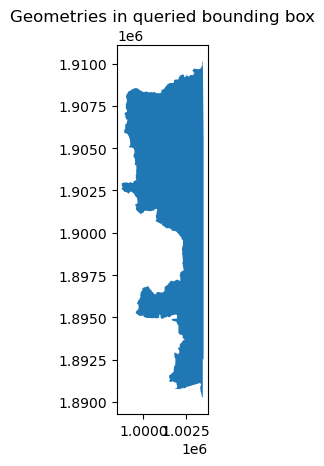

In [47]:
subset_gdf = kc_dataset.gdf.cx[bbox.minx:bbox.maxx, bbox.miny:bbox.maxy]
print("Number of geometries in bounding box:", len(subset_gdf))
subset_gdf.plot()
plt.title("Geometries in queried bounding box")
plt.show()

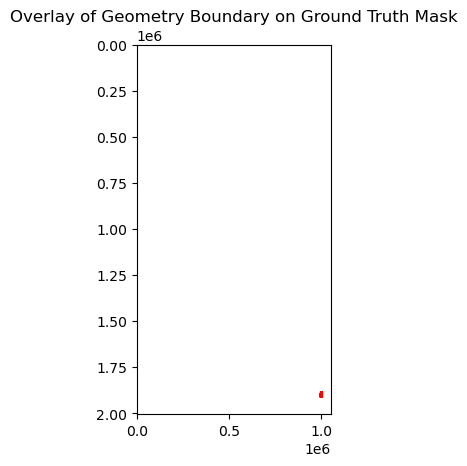

In [50]:
plt.imshow(gt_mask, cmap="gray", alpha=0.5)
subset_gdf.boundary.plot(color="red", ax=plt.gca(), linewidth=2)
plt.title("Overlay of Geometry Boundary on Ground Truth Mask")
plt.show()

In [51]:
print("Vector CRS:", kc_dataset.gdf.crs)
print("NAIP CRS:", naip_dataset.crs)

Vector CRS: EPSG:3435
NAIP CRS: EPSG:26916


Loading vector data...
Loading vector data from path: /net/projects/cmap/data/kane-county-data/KC_CountywideDepressionalStorage_Aug2020.gdb, layer: DepressionalStorage
'BasinType' not found. Available keys: ['ContourMin', 'ContourMax', 'Shape_Leng', 'fid_1', 'Shape_Length', 'Shape_Area']
Falling back to 'fid_1'.
GeoDataFrame has no CRS. Setting CRS to EPSG:3435.
Loaded 100 vector features. Assigned default label 1 to all features.
Converting vector data to CRS EPSG:3435...
Finished loading vector data.
Vector bounds: [ 393787.45247692 4634601.42842959  395289.99622274 4640655.6392401 ]
NAIP dataset CRS: EPSG:26916


<Figure size 800x800 with 0 Axes>

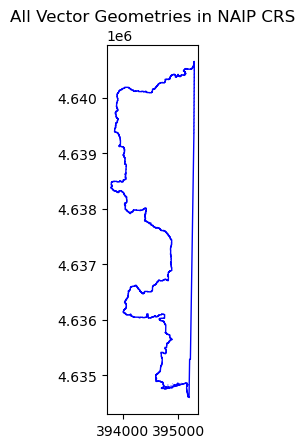

Attempt 1: Geometry bounds = (394775.694693022, 4634786.6343824165, 394778.83872948727, 4634787.582889408)
Tile intersects selected geometry: True
Ground truth mask unique values: [0]
Attempt 1: No valid tile found. Retrying...
Attempt 2: Geometry bounds = (394804.5791570536, 4634781.500564, 394804.6355654109, 4634781.555444249)
Tile intersects selected geometry: True
Ground truth mask unique values: [0]
Attempt 2: No valid tile found. Retrying...
Attempt 3: Geometry bounds = (394830.6768444014, 4634788.774533258, 394831.07210212323, 4634789.155197237)
Tile intersects selected geometry: True
Ground truth mask unique values: [0]
Attempt 3: No valid tile found. Retrying...
Attempt 4: Geometry bounds = (394774.5842248404, 4634786.152010693, 394775.60432543483, 4634786.5268081)
Tile intersects selected geometry: True
Ground truth mask unique values: [0]
Attempt 4: No valid tile found. Retrying...
Attempt 5: Geometry bounds = (394993.1316828334, 4634849.774292308, 394993.7147726837, 4634849

ValueError: No valid vector tile found after 50 attempts.

In [61]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from torchgeo.datasets import BoundingBox, NAIP
from shapely.geometry import box
import geopandas as gpd
from kc import KaneCounty

# --- Configuration ---
vector_path = "/net/projects/cmap/data/kane-county-data/KC_CountywideDepressionalStorage_Aug2020.gdb"
layer = "DepressionalStorage"
vector_crs = "EPSG:3435"
default_labels = {0: "BACKGROUND", 1: "OBJECT"}
dataset_config = (layer, default_labels, 256, vector_crs, 1.0)

# --- Load data ---
print("Loading vector data...")
kc_dataset = KaneCounty(vector_path, dataset_config)
kc_dataset.gdf = kc_dataset.gdf.to_crs("EPSG:26916")  # Transform to NAIP CRS
vector_bounds = kc_dataset.gdf.total_bounds  # [minx, miny, maxx, maxy]
print("Vector bounds:", vector_bounds)

naip_dataset = NAIP("/net/projects/cmap/data/KC-images")
print("NAIP dataset CRS:", naip_dataset.crs)

# --- Visualize all geometries ---
plt.figure(figsize=(8, 8))
kc_dataset.gdf.plot(edgecolor="blue", facecolor="none")
plt.title("All Vector Geometries in NAIP CRS")
plt.show()

# --- Helper to get a valid tile ---
def get_valid_tile():
    geometries = kc_dataset.gdf.geometry
    for attempt in range(50):
        # Randomly sample a geometry and print its bounds
        selected_geom = geometries.sample(1).iloc[0]
        geom_bounds = selected_geom.bounds
        print(f"Attempt {attempt + 1}: Geometry bounds = {geom_bounds}")

        # Define a tile centered on the geometry bounds
        minx, miny, maxx, maxy = geom_bounds
        center_x, center_y = (minx + maxx) / 2, (miny + maxy) / 2
        tile_size = 300  # Try increasing this size

        bbox = BoundingBox(
            minx=center_x - tile_size / 2,
            maxx=center_x + tile_size / 2,
            miny=center_y - tile_size / 2,
            maxy=center_y + tile_size / 2,
            mint=0,
            maxt=2**63 - 1
        )

        # Check if the bounding box intersects with the geometry
        intersects = selected_geom.intersects(box(bbox.minx, bbox.miny, bbox.maxx, bbox.maxy))
        print(f"Tile intersects selected geometry: {intersects}")

        if intersects:
            # Query the dataset to get the mask
            sample = kc_dataset[bbox]
            gt_mask = sample["mask"].numpy()
            print(f"Ground truth mask unique values: {np.unique(gt_mask)}")

            # Check if the mask has non-background pixels
            if np.sum(gt_mask != 0) > 0:
                print(f"Found valid vector tile on attempt {attempt + 1}.")
                return bbox, gt_mask

        print(f"Attempt {attempt + 1}: No valid tile found. Retrying...")

    raise ValueError("No valid vector tile found after 50 attempts.")

# --- Run the tile sampling ---
bbox, gt_mask = get_valid_tile()
print("Ground truth mask shape:", gt_mask.shape)

# --- Visualize the sampled geometry and tile ---
plt.figure(figsize=(8, 8))
kc_dataset.gdf.plot(edgecolor="blue", facecolor="none", alpha=0.5)
plt.title("Vector Geometries and Sampled Tile")
plt.axvline(bbox.minx, color="red", linestyle="--")
plt.axvline(bbox.maxx, color="red", linestyle="--")
plt.axhline(bbox.miny, color="red", linestyle="--")
plt.axhline(bbox.maxy, color="red", linestyle="--")
plt.show()

# --- Visualize the ground truth mask ---
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.colorbar()
plt.show()


Loading vector data...
Loading vector data from path: /net/projects/cmap/data/kane-county-data/KC_CountywideDepressionalStorage_Aug2020.gdb, layer: DepressionalStorage
'BasinType' not found. Available keys: ['ContourMin', 'ContourMax', 'Shape_Leng', 'fid_1', 'Shape_Length', 'Shape_Area']
Falling back to 'fid_1'.
GeoDataFrame has no CRS. Setting CRS to EPSG:3435.
Loaded 100 vector features. Assigned default label 1 to all features.
Converting vector data to CRS EPSG:3435...
Finished loading vector data.
Vector bounds: [ 998695.99980292 1890264.00001167 1003551.99993342 1910133.99996975]
NAIP dataset CRS: EPSG:26916
Tile intersects selected geometry: True
Found valid vector tile on attempt 1.
Ground truth mask shape: (1024, 1024)


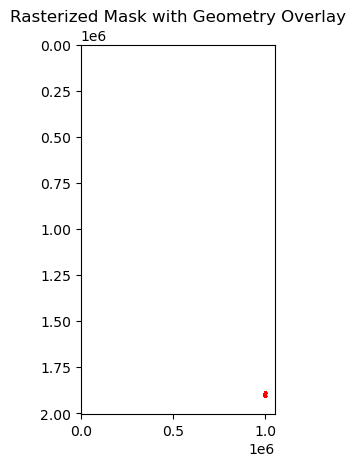

NAIP image shape (native CRS): (300, 309, 4)
Resized NAIP image shape: (1024, 1024, 4)
Predicted mask shape: (1024, 1024)
IOU between predicted mask and ground truth: 0.0013408660888671875


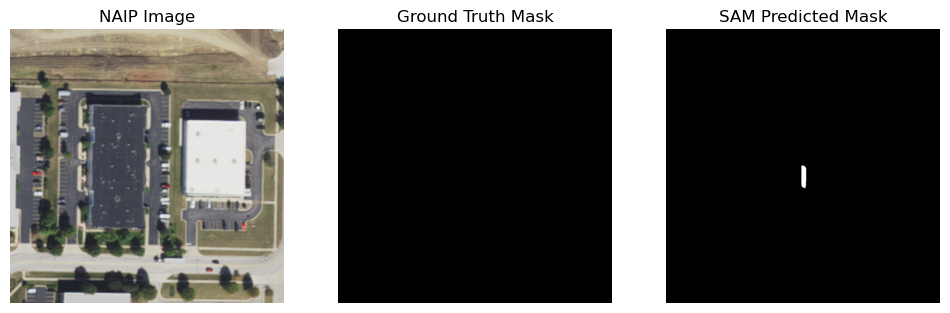

In [66]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from torchgeo.datasets import BoundingBox, NAIP
from pyproj import Transformer
from PIL import Image
import geopandas as gpd
import rasterio
from rasterio.features import rasterize

from kc import KaneCounty

# --- Configuration parameters ---
vector_path = "/net/projects/cmap/data/kane-county-data/KC_CountywideDepressionalStorage_Aug2020.gdb"
layer = "DepressionalStorage"
vector_crs = "EPSG:3435"  # assumed vector CRS
default_labels = {0: "BACKGROUND", 1: "OBJECT"}
dataset_config = (layer, default_labels, 256, vector_crs, 1.0)

# --- Load the KaneCounty vector dataset ---
print("Loading vector data...")
kc_dataset = KaneCounty(vector_path, dataset_config)
print("Vector bounds:", kc_dataset.gdf.total_bounds)

# --- Load NAIP dataset ---
naip_dataset = NAIP("/net/projects/cmap/data/KC-images")
print("NAIP dataset CRS:", naip_dataset.crs)

# --- Helper function to query a valid tile ---
def get_valid_tile():
    tile_size = 500  # Increased tile size
    buffer_size = 50  # Add buffer to the bounding box
    minx, miny, maxx, maxy = kc_dataset.gdf.total_bounds

    for attempt in range(50):
        rand_minx = random.uniform(minx, maxx - tile_size)
        rand_miny = random.uniform(miny, maxy - tile_size)
        bbox = BoundingBox(
            minx=rand_minx - buffer_size, maxx=rand_minx + tile_size + buffer_size,
            miny=rand_miny - buffer_size, maxy=rand_miny + tile_size + buffer_size,
            mint=0, maxt=2**63-1
        )

        # Check if any geometry intersects this bounding box
        subset_gdf = kc_dataset.gdf.cx[bbox.minx:bbox.maxx, bbox.miny:bbox.maxy]
        if subset_gdf.empty:
            print(f"Attempt {attempt + 1}: No geometries found in bbox {bbox}. Retrying...")
            continue

        print("Tile intersects selected geometry:", not subset_gdf.empty)

        # Rasterize the geometries
        transform = rasterio.transform.from_bounds(
            bbox.minx, bbox.miny, bbox.maxx, bbox.maxy, width=1024, height=1024
        )
        mask = rasterize(
            [(geom, 1) for geom in subset_gdf.geometry],
            out_shape=(1024, 1024),
            transform=transform,
            fill=0,
            all_touched=True,
            dtype=np.uint8
        )

        if np.sum(mask) > 0:
            print(f"Found valid vector tile on attempt {attempt + 1}.")
            return bbox, mask

        print(f"Attempt {attempt + 1}: No valid tile found. Retrying...")

    raise ValueError("No valid vector tile found after 50 attempts.")

# --- Query a valid vector tile ---
bbox, gt_mask = get_valid_tile()
print("Ground truth mask shape:", gt_mask.shape)

# --- Visualize the sampled geometry and tile ---
plt.imshow(gt_mask, cmap="gray", alpha=0.5)
kc_dataset.gdf.cx[bbox.minx:bbox.maxx, bbox.miny:bbox.maxy].boundary.plot(color="red", ax=plt.gca(), linewidth=2)
plt.title("Rasterized Mask with Geometry Overlay")
plt.show()

# --- Load and transform the NAIP tile ---
transformer = Transformer.from_crs(vector_crs, naip_dataset.crs, always_xy=True)
new_minx, new_miny = transformer.transform(bbox.minx, bbox.miny)
new_maxx, new_maxy = transformer.transform(bbox.maxx, bbox.maxy)
bbox_naip = BoundingBox(minx=new_minx, maxx=new_maxx, miny=new_miny, maxy=new_maxy, mint=0, maxt=2**63-1)
naip_sample = naip_dataset[bbox_naip]
naip_image = naip_sample["image"].permute(1, 2, 0).numpy().astype(np.uint8)
print("NAIP image shape (native CRS):", naip_image.shape)

# --- Resize the NAIP image to exactly 1024x1024 ---
pil_img = Image.fromarray(naip_image)
pil_img = pil_img.resize((1024, 1024), Image.BILINEAR)
resized_naip = np.array(pil_img)
print("Resized NAIP image shape:", resized_naip.shape)

# --- Ensure NAIP image has 3 channels ---
if resized_naip.shape[2] > 3:
    resized_naip = resized_naip[:, :, :3]

# --- Use SAM to predict a mask ---
from segment_anything import SamPredictor, sam_model_registry
model_type = "vit_h"
checkpoint_path = "/home/gregoryc25/CMAP/segment-anything/sam_vit_h.pth"
sam_model = sam_model_registry[model_type](checkpoint=checkpoint_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model.to(device)
predictor = SamPredictor(sam_model)
predictor.set_image(resized_naip)
point_coords = np.array([[512, 512]])
masks, scores, logits = predictor.predict(
    point_coords=point_coords,
    point_labels=[1],
    multimask_output=False
)
pred_mask = masks[0].astype(np.uint8)
print("Predicted mask shape:", pred_mask.shape)

# --- Compute IOU ---
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1 > 0, mask2 > 0).sum()
    union = np.logical_or(mask1 > 0, mask2 > 0).sum()
    return intersection / union if union > 0 else 0

iou_value = compute_iou(pred_mask, gt_mask)
print("IOU between predicted mask and ground truth:", iou_value)

# --- Visualize results ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(resized_naip)
plt.title("NAIP Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")
plt.title("SAM Predicted Mask")
plt.axis("off")
plt.show()


In [70]:
import fiona

vector_path = "/net/projects/cmap/data/kane-county-data/KC_CountywideDepressionalStorage_Aug2020.gdb"

# Open the layer and inspect the first feature's properties in detail
with fiona.open(vector_path, layer="DepressionalStorage") as src:
    feature = next(iter(src))
    properties = dict(feature["properties"])  # Cast to dictionary
    print("Feature properties (as dictionary):", properties)
    print("Geometry type:", feature["geometry"]["type"])
    print("Available property keys:", properties.keys())


Feature properties (as dictionary): {'ContourMin': 0.0, 'ContourMax': 7.82739257813, 'Shape_Leng': 70040.0, 'fid_1': None, 'Shape_Length': 23.999952003359795, 'Shape_Area': 19.999919995745557}
Geometry type: MultiPolygon
Available property keys: dict_keys(['ContourMin', 'ContourMax', 'Shape_Leng', 'fid_1', 'Shape_Length', 'Shape_Area'])


Loading vector data...
Loading vector data from path: /net/projects/cmap/data/kane-county-data/KC_CountywideDepressionalStorage_Aug2020.gdb, layer: DepressionalStorage
'BasinType' not found. Available keys: ['ContourMin', 'ContourMax', 'Shape_Leng', 'fid_1', 'Shape_Length', 'Shape_Area']
Falling back to 'fid_1'.
GeoDataFrame has no CRS. Setting CRS to EPSG:3435.
Loaded 100 vector features. Assigned default label 1 to all features.
Converting vector data to CRS EPSG:3435...
Finished loading vector data.
Vector bounds: [ 998695.99980292 1890264.00001167 1003551.99993342 1910133.99996975]
Available columns in vector data: Index(['Label', 'geometry'], dtype='object')
Found valid vector tile on attempt 1.
Ground truth mask shape: (46, 70)


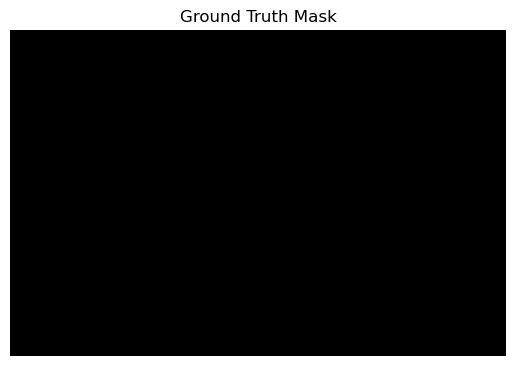

NAIP dataset CRS: EPSG:26916
NAIP dataset bounds: BoundingBox(minx=364464.6, maxx=402285.0, miny=4615590.600000001, maxy=4672227.6, mint=1630818000.0, maxt=1632891599.999999)
Transformed bounding box for NAIP query: BoundingBox(minx=394480.4192367769, maxx=394501.994948986, miny=4638739.798151532, maxy=4638753.343991972, mint=0, maxt=9223372036854775807)
NAIP image shape: (23, 36, 4)
Resized NAIP RGB image shape: (1024, 1024, 3)
Resized ground truth mask shape: (1024, 1024)
Predicted mask shape: (1024, 1024)
IOU between predicted mask and ground truth: 0.4221067428588867


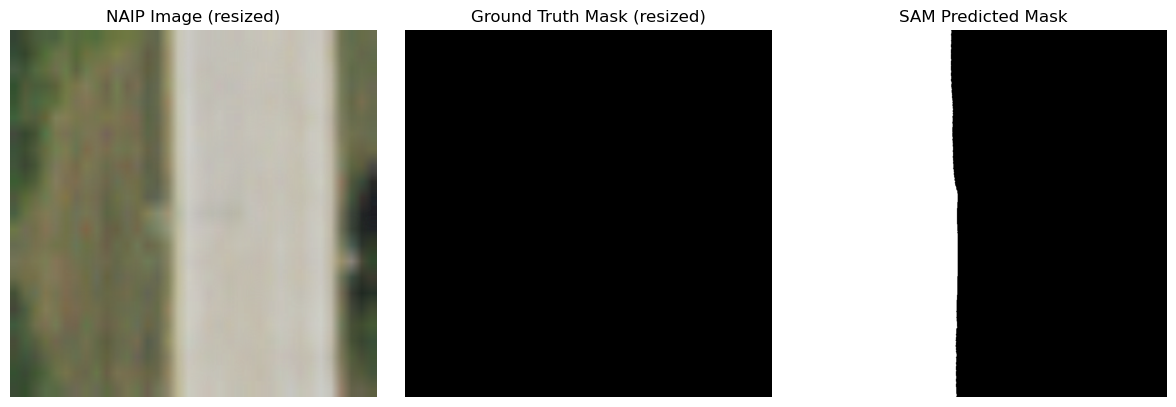

In [74]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from torchgeo.datasets import BoundingBox, NAIP
from pyproj import Transformer
from PIL import Image
from kc import KaneCounty
from segment_anything import SamPredictor, sam_model_registry

# --- Configuration parameters ---
vector_path = "/net/projects/cmap/data/kane-county-data/KC_CountywideDepressionalStorage_Aug2020.gdb"
layer = "DepressionalStorage"
vector_crs = "EPSG:3435"
default_labels = {0: "BACKGROUND", 1: "OBJECT"}
dataset_config = (layer, default_labels, 256, vector_crs, 1.0)

# --- Load the KaneCounty vector dataset ---
print("Loading vector data...")
kc_dataset = KaneCounty(vector_path, dataset_config)
print("Vector bounds:", kc_dataset.gdf.total_bounds)
print("Available columns in vector data:", kc_dataset.gdf.columns)

# --- Function to get a valid tile ---
def get_valid_tile(attempts=50):
    minx_total, miny_total, maxx_total, maxy_total = kc_dataset.gdf.total_bounds

    for attempt in range(attempts):
        rand_minx = random.uniform(minx_total, maxx_total - 50)
        rand_maxx = rand_minx + random.uniform(10, 100)
        rand_miny = random.uniform(miny_total, maxy_total - 50)
        rand_maxy = rand_miny + random.uniform(10, 100)

        bbox = BoundingBox(
            minx=rand_minx, maxx=rand_maxx,
            miny=rand_miny, maxy=rand_maxy,
            mint=0, maxt=2**63-1
        )

        sample = kc_dataset[bbox]
        gt_mask = sample["mask"].numpy()

        if np.any(gt_mask):
            print(f"Found valid vector tile on attempt {attempt + 1}.")
            return bbox, gt_mask

        print(f"Attempt {attempt + 1}: No valid tile found. Retrying...")

    raise ValueError("No valid vector tile found after 50 attempts.")

# --- Query a valid tile ---
bbox, gt_mask = get_valid_tile()
print("Ground truth mask shape:", gt_mask.shape)

# --- Visualize the ground truth mask ---
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")
plt.show()

# --- Load NAIP imagery ---
naip_dataset = NAIP("/net/projects/cmap/data/KC-images")
print("NAIP dataset CRS:", naip_dataset.crs)
print("NAIP dataset bounds:", naip_dataset.bounds)

# --- Transform vector bounding box to NAIP CRS ---
transformer = Transformer.from_crs(vector_crs, naip_dataset.crs, always_xy=True)
new_minx, new_miny = transformer.transform(bbox.minx, bbox.miny)
new_maxx, new_maxy = transformer.transform(bbox.maxx, bbox.maxy)
bbox_naip = BoundingBox(minx=new_minx, maxx=new_maxx, miny=new_miny, maxy=new_maxy, mint=bbox.mint, maxt=bbox.maxt)
print("Transformed bounding box for NAIP query:", bbox_naip)

# --- Query the NAIP tile ---
naip_sample = naip_dataset[bbox_naip]
naip_image = naip_sample["image"].permute(1, 2, 0).numpy().astype(np.uint8)
print("NAIP image shape:", naip_image.shape)

# --- Resize the NAIP image to 1024x1024 ---
pil_img = Image.fromarray(naip_image)
pil_img = pil_img.resize((1024, 1024), Image.BILINEAR)
resized_naip = np.array(pil_img)

if resized_naip.shape[2] > 3:
    resized_naip = resized_naip[:, :, :3]
print("Resized NAIP RGB image shape:", resized_naip.shape)

# --- Resize the ground truth mask to 1024x1024 ---
pil_mask = Image.fromarray(gt_mask.astype(np.uint8))
pil_mask = pil_mask.resize((1024, 1024), Image.NEAREST)
resized_gt = np.array(pil_mask)
print("Resized ground truth mask shape:", resized_gt.shape)

# --- Use SAM to predict a mask ---
model_type = "vit_h"
checkpoint_path = "/home/gregoryc25/CMAP/segment-anything/sam_vit_h.pth"
sam_model = sam_model_registry[model_type](checkpoint=checkpoint_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model.to(device)

predictor = SamPredictor(sam_model)
predictor.set_image(resized_naip)
prompt_point = [int(gt_mask.shape[1] // 2), int(gt_mask.shape[0] // 2)]
point_coords = np.array([prompt_point])
masks, scores, logits = predictor.predict(
    point_coords=point_coords,
    point_labels=[1],
    multimask_output=False
)
pred_mask = masks[0].astype(np.uint8)
print("Predicted mask shape:", pred_mask.shape)

# --- Compute IOU ---
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1 > 0, mask2 > 0).sum()
    union = np.logical_or(mask1 > 0, mask2 > 0).sum()
    return intersection / union if union > 0 else 0

iou_value = compute_iou(pred_mask, resized_gt)
print("IOU between predicted mask and ground truth:", iou_value)

# --- Visualize results ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(resized_naip)
plt.title("NAIP Image (resized)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(resized_gt, cmap="gray")
plt.title("Ground Truth Mask (resized)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")
plt.title("SAM Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
